In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import rioxarray as rx
from tqdm import tqdm
import seaborn as sns 
import pandas as pd
import xarray as xr
from tqdm import trange, tqdm, tqdm_notebook
from shapely.geometry import Polygon
import cartopy

### South America

In [7]:
#RZS_TC = pd.read_pickle('/home/chandra/data/Stable_unstable_paper/Dataframe_updated_SA-29.03.2021.pkl')
RZS_TC = pd.read_pickle('/Input_data/Dataframe_updated_SA-29.03.2021.pkl')

len(RZS_TC) 

for classes in [11,14,20,30,190,200,210,220]:
    RZS_TC = RZS_TC[RZS_TC.Landuse != int(classes)]

In [8]:
RZS_TC['Mean_TC'] = RZS_TC['Mean_Treecover']

RZS_TC[['Sr','MAP','Mean_Treecover','TC_f-i']].columns.values

RZS_TC.loc[RZS_TC['Mean_Treecover'] <= 50, 'Mean_Treecover' ] = 0
RZS_TC.loc[RZS_TC['Mean_Treecover'] > 50, 'Mean_Treecover' ] = 1

RZS_TC['TC_f-i_mod'] = RZS_TC['TC_f-i'].abs()

RZS_TC.rename(columns = {'TC_f-i_mod' : 'delTCmod'}, inplace = True)

print(RZS_TC['Sr'].where(RZS_TC['Mean_TC'] > 50).dropna().quantile(0.99))

RZS_TC['Sr_expendable'] = RZS_TC['Sr']

print('Sr_max_99th-percentile')
RZS_TC.loc[RZS_TC['Mean_TC'] < 30, 'Sr_expendable' ] = RZS_TC['Sr'].where(RZS_TC['Mean_TC'] > 50).dropna().quantile(0.99)

717.9348059082033
Sr_max_99th-percentile


#### Only $\overline{P}$ Resilience

In [10]:
from statsmodels.formula.api import mnlogit
import statsmodels.api as sm
model = mnlogit("Mean_Treecover ~ MAP", RZS_TC).fit()
print(model.summary2())

Optimization terminated successfully.
         Current function value: 0.449438
         Iterations 7
                          Results: MNLogit
Model:                MNLogit          Pseudo R-squared: 0.351      
Dependent Variable:   Mean_Treecover   AIC:              638263.4565
Date:                 2021-08-15 17:11 BIC:              638286.4027
No. Observations:     710064           Log-Likelihood:   -3.1913e+05
Df Model:             1                LL-Null:          -4.9210e+05
Df Residuals:         710062           LLR p-value:      0.0000     
Converged:            1.0000           Scale:            1.0000     
No. Iterations:       7.0000                                        
--------------------------------------------------------------------
Mean_Treecover = 0  Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------
         Intercept -3.8007   0.0095 -399.5920 0.0000 -3.8194 -3.7821
               MAP  0.0021 

In [11]:
prediction_1 = model.predict(sm.add_constant(RZS_TC[['MAP']]))[1]

RZS_TC = pd.concat([RZS_TC,prediction_1], axis = 1)

RZS_TC = RZS_TC.rename(columns={1: "Pred_P"})

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### Only $S_r$

In [12]:
from statsmodels.formula.api import mnlogit
import statsmodels.api as sm
model = mnlogit("Mean_Treecover ~ Sr_expendable", RZS_TC).fit()
print(model.summary2())

Optimization terminated successfully.
         Current function value: 0.409939
         Iterations 6
                          Results: MNLogit
Model:                MNLogit          Pseudo R-squared: 0.408      
Dependent Variable:   Mean_Treecover   AIC:              582170.4374
Date:                 2021-08-15 17:11 BIC:              582193.3837
No. Observations:     710064           Log-Likelihood:   -2.9108e+05
Df Model:             1                LL-Null:          -4.9210e+05
Df Residuals:         710062           LLR p-value:      0.0000     
Converged:            1.0000           Scale:            1.0000     
No. Iterations:       6.0000                                        
--------------------------------------------------------------------
Mean_Treecover = 0  Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------
         Intercept  4.5135   0.0106  423.8669 0.0000  4.4926  4.5344
     Sr_expendable -0.0089 

### $\overline{P} + S_r$

In [13]:
from statsmodels.formula.api import mnlogit
import statsmodels.api as sm
model = mnlogit("Mean_Treecover ~ MAP+ Sr_expendable", RZS_TC).fit()
print(model.summary2())

Optimization terminated successfully.
         Current function value: 0.353325
         Iterations 7
                          Results: MNLogit
Model:                MNLogit          Pseudo R-squared: 0.490      
Dependent Variable:   Mean_Treecover   AIC:              501772.3395
Date:                 2021-08-15 17:11 BIC:              501806.7588
No. Observations:     710064           Log-Likelihood:   -2.5088e+05
Df Model:             2                LL-Null:          -4.9210e+05
Df Residuals:         710061           LLR p-value:      0.0000     
Converged:            1.0000           Scale:            1.0000     
No. Iterations:       7.0000                                        
--------------------------------------------------------------------
Mean_Treecover = 0  Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------
         Intercept  0.7471   0.0161   46.3284 0.0000  0.7155  0.7787
               MAP  0.0015 

In [15]:
prediction = model.predict(sm.add_constant(RZS_TC[['MAP','Sr_expendable']]))[1]

In [16]:
RZS_TC = pd.concat([RZS_TC,prediction], axis = 1)

In [17]:
RZS_TC = RZS_TC.rename(columns={1: "Pred"})

In [18]:
RZS_TC

,Sr,Mean_Treecover,Landuse,TC_f-i,MAP,Sr_ERA5_1999,Sr_ERA5_2019,Mean_TC,delTCmod,Sr_expendable,Pred_P,Pred
302993741,452.975647,1.0,40,2.666672,2159.297363,483.573303,550.008301,70.849998,2.666672,452.975647,0.694682,0.713240
217364332,65.615341,1.0,40,8.000000,3242.351807,41.097538,57.304607,74.900002,8.000000,65.615341,0.958545,0.994017
390863334,493.124054,0.0,130,5.666666,1617.215454,445.798920,530.043701,16.700001,5.666666,717.934814,0.416189,0.158661
446559668,498.373383,0.0,40,-8.000000,1095.183105,514.598145,597.245667,26.100000,8.000000,717.934814,0.189072,0.080031
246078364,98.981110,1.0,40,-4.000000,2804.615234,56.399117,81.555977,76.900002,4.000000,98.981110,0.900578,0.985802
...,...,...,...,...,...,...,...,...,...,...,...,...
636292595,177.204498,0.0,130,4.000000,1119.488281,352.297333,438.419403,13.300000,4.000000,717.934814,0.197179,0.082724
152768034,233.869293,1.0,40,1.666664,2189.294434,197.597321,195.383240,72.599998,1.666664,233.869293,0.708131,0.918659
179696011,429.612793,1.0,40,-7.000000,2163.687744,250.489059,240.804581,74.699997,7.000000,429.612793,0.696672,0.745410
334094970,506.924286,1.0,40,2.000000,2238.122070,360.010284,368.207764,76.500000,2.000000,506.924286,0.729257,0.660694


### Supplementary Fi. 6a

<ipython-input-19-acf448e12f89>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([' '])
<ipython-input-19-acf448e12f89>:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([' '])
<ipython-input-19-acf448e12f89>:123: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([' '])
<ipython-input-19-acf448e12f89>:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([' ',0.2,0.4,0.6,0.8,1])


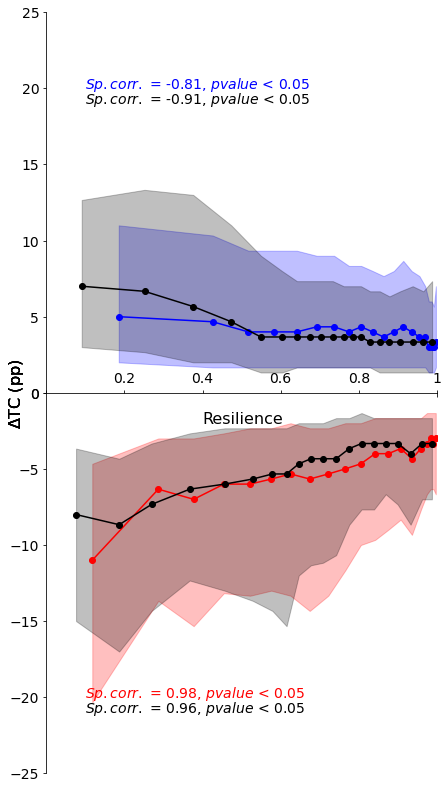

In [19]:
fig = plt.figure(figsize=(7,14))
ax = [plt.subplot(211), plt.subplot(212)]
fig.subplots_adjust(wspace=0.0)
fig.subplots_adjust(hspace=0.0)


a = RZS_TC[['Pred','TC_f-i','Pred_P']].where((RZS_TC['Mean_TC'] >30) & (RZS_TC['TC_f-i'] >= 0)).dropna()
pixel_4 = round(len(a['Pred'].sort_values())/20)

Res_bins = []
Res_bins.append(0)
for i in range(20):
    if i < 19:
        Res_bins.append((a['Pred'].sort_values()[pixel_4*i:pixel_4*(i+1)]).max())
    else:
        Res_bins.append((a['Pred'].sort_values()[pixel_4*i:].max()))

Res_bins[20] = 1
res = []
res_25 = []
res_75 = []
n = []
Res_bins_cen = []
for i in range(np.array(Res_bins).shape[0]-1):
    Res_bins_cen.append((Res_bins[i]+Res_bins[i+1])/2)
for i in range(np.array(Res_bins).shape[0]-1):
    b = a.where((a['Pred'] >= Res_bins[i]) & (a['Pred'] < Res_bins[i+1])).dropna()
    res.append(b['TC_f-i'].median())
    n.append(b['TC_f-i'].size)
    res_25.append(b['TC_f-i'].quantile(0.25))
    res_75.append(b['TC_f-i'].quantile(0.75))
ax[0].plot(np.array(Res_bins_cen),res, '-o', color = 'b')
ax[0].fill_between(np.array(Res_bins_cen),res_25,res_75, alpha = 0.25, color = 'b')
ax[0].set_ylim(0,25)
ax[0].set_xlim(0,1)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].text(-0.1,-2, r'$\Delta {}$'+'TC (pp)', fontsize = '16', rotation = 90)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_xticklabels([' '])
from scipy import stats
cor, p = stats.spearmanr(np.array(Res_bins_cen),res)
if p <= 0.05:
    ax[0].text(0.1,20, r'$Sp. corr.$ = '+str(round(cor,2))+ r', $pvalue$ < 0.05', color = 'b', fontsize = '14')
else:
    ax[0].text(0.1,20, r'$Sp. corr.$ = '+str(round(cor,2))+ r', $pvalue$ = '+str(round(p,2)), color = 'b', fontsize = '14')


pixel_4 = round(len(a['Pred_P'].sort_values())/20)
Res_bins = []
Res_bins.append(0)
for i in range(20):
    if i < 19:
        Res_bins.append((a['Pred_P'].sort_values()[pixel_4*i:pixel_4*(i+1)]).max())
    else:
        Res_bins.append((a['Pred_P'].sort_values()[pixel_4*i:].max()))

Res_bins[20] = 1
res = []
res_25 = []
res_75 = []
n = []
Res_bins_cen = []
for i in range(np.array(Res_bins).shape[0]-1):
    Res_bins_cen.append((Res_bins[i]+Res_bins[i+1])/2)
for i in range(np.array(Res_bins).shape[0]-1):
    b = a.where((a['Pred_P'] >= Res_bins[i]) & (a['Pred_P'] < Res_bins[i+1])).dropna()
    res.append(b['TC_f-i'].median())
    n.append(b['TC_f-i'].size)
    res_25.append(b['TC_f-i'].quantile(0.25))
    res_75.append(b['TC_f-i'].quantile(0.75))
ax[0].plot(np.array(Res_bins_cen),res, '-o', color = 'black')
ax[0].fill_between(np.array(Res_bins_cen),res_25,res_75, alpha = 0.25, color = 'black')
ax[0].set_ylim(0,25)
ax[0].set_xlim(0,1)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].text(-0.1,-2, r'$\Delta {}$'+'TC (pp)', fontsize = '16', rotation = 90)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_xticklabels([' '])
from scipy import stats
cor, p = stats.spearmanr(np.array(Res_bins_cen),res)
if p <= 0.05:
    ax[0].text(0.1,19, r'$Sp. corr.$ = '+str(round(cor,2))+ r', $pvalue$ < 0.05', color = 'black', fontsize = '14')
else:
    ax[0].text(0.1,19, r'$Sp. corr.$ = '+str(round(cor,2))+ r', $pvalue$ = '+str(round(p,2)), color = 'black', fontsize = '14')


a = RZS_TC[['Pred','TC_f-i','Pred_P']].where((RZS_TC['Mean_TC'] >30) & (RZS_TC['TC_f-i'] < 0)).dropna()

pixel_4 = round(len(a['Pred'].sort_values())/20)
Res_bins = []
Res_bins.append(0)
for i in range(20):
    if i < 19:
        Res_bins.append((a['Pred'].sort_values()[pixel_4*i:pixel_4*(i+1)]).max())
    else:
        Res_bins.append((a['Pred'].sort_values()[pixel_4*i:].max()))

Res_bins[20] = 1

res = []
res_25 = []
res_75 = []
n = []
Res_bins_cen = []
for i in range(np.array(Res_bins).shape[0]-1):
    Res_bins_cen.append((Res_bins[i]+Res_bins[i+1])/2)
for i in range(np.array(Res_bins).shape[0]-1):
    b = a.where((a['Pred'] >= Res_bins[i]) & (a['Pred'] < Res_bins[i+1])).dropna()
    res.append(b['TC_f-i'].median())
    n.append(b['TC_f-i'].size)
    res_25.append(b['TC_f-i'].quantile(0.25))
    res_75.append(b['TC_f-i'].quantile(0.75))
ax[1].plot(np.array(Res_bins_cen),res, '-o', color = 'r')
ax[1].fill_between(np.array(Res_bins_cen),res_25,res_75, alpha = 0.25, color = 'r')
ax[1].set_ylim(-25,0)
ax[1].set_xlim(0,1)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].text(-0.1,-2, r'$\Delta {}$'+'TC (pp)', fontsize = '16', rotation = 90)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].set_xticklabels([' '])
from scipy import stats
cor, p = stats.spearmanr(np.array(Res_bins_cen),res)

if p <= 0.05:
    ax[1].text(0.1,-20, r'$Sp. corr.$ = '+str(round(cor,2))+ r', $pvalue$ < 0.05', color = 'r', fontsize = '14')
else:
    ax[1].text(0.1,-20, r'$Sp. corr.$ = '+str(round(cor,2))+ r', $pvalue$ = '+str(round(p,2)), color = 'r', fontsize = '14')

    
pixel_4 = round(len(a['Pred_P'].sort_values())/20)
Res_bins = []
Res_bins.append(0)
for i in range(20):
    if i < 19:
        Res_bins.append((a['Pred_P'].sort_values()[pixel_4*i:pixel_4*(i+1)]).max())
    else:
        Res_bins.append((a['Pred_P'].sort_values()[pixel_4*i:].max()))

Res_bins[20] = 1

res = []
res_25 = []
res_75 = []
n = []
Res_bins_cen = []
for i in range(np.array(Res_bins).shape[0]-1):
    Res_bins_cen.append((Res_bins[i]+Res_bins[i+1])/2)
for i in range(np.array(Res_bins).shape[0]-1):
    b = a.where((a['Pred_P'] >= Res_bins[i]) & (a['Pred_P'] < Res_bins[i+1])).dropna()
    res.append(b['TC_f-i'].median())
    n.append(b['TC_f-i'].size)
    res_25.append(b['TC_f-i'].quantile(0.25))
    res_75.append(b['TC_f-i'].quantile(0.75))
ax[1].plot(np.array(Res_bins_cen),res, '-o', color = 'black')
ax[1].fill_between(np.array(Res_bins_cen),res_25,res_75, alpha = 0.25, color = 'black')
ax[1].set_ylim(-25,0)
ax[1].set_xlim(0,1)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].text(-0.1,-2, r'$\Delta {}$'+'TC (pp)', fontsize = '16', rotation = 90)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].set_xticklabels([' ',0.2,0.4,0.6,0.8,1])
ax[1].set_xlim(0,1)
ax[1].xaxis.tick_top()
ax[1].text(0.4,-2, 'Resilience', fontsize = '16')
from scipy import stats
cor, p = stats.spearmanr(np.array(Res_bins_cen),res)
if p <= 0.05:
    ax[1].text(0.1,-21, r'$Sp. corr.$ = '+str(round(cor,2))+ r', $pvalue$ < 0.05', color = 'black', fontsize = '14')
else:
    ax[1].text(0.1,-21, r'$Sp. corr.$ = '+str(round(cor,2))+ r', $pvalue$ = '+str(round(p,2)), color = 'black', fontsize = '14')


----------------------------------------------------------------------------------------------------

### For Africa

In [3]:
#RZS_TC = pd.read_pickle('/home/chandra/data/Stable_unstable_paper/Dataframe_updated_AF-29.03.2021.pkl')
RZS_TC = pd.read_pickle('/Input_data/Dataframe_updated_AF-29.03.2021.pkl')

for classes in [11,14,20,30,190,200,210,220,230]:
    RZS_TC = RZS_TC[RZS_TC.Landuse != int(classes)]

In [4]:
RZS_TC['Mean_TC'] = RZS_TC['Mean_Treecover']

RZS_TC[['Sr','MAP','Mean_Treecover','TC_f-i']].columns.values

RZS_TC.loc[RZS_TC['Mean_Treecover'] <= 50, 'Mean_Treecover' ] = 0
RZS_TC.loc[RZS_TC['Mean_Treecover'] > 50, 'Mean_Treecover' ] = 1

RZS_TC['TC_f-i_mod'] = RZS_TC['TC_f-i'].abs()

RZS_TC.rename(columns = {'TC_f-i_mod' : 'delTCmod'}, inplace = True)

print(RZS_TC['Sr'].where(RZS_TC['Mean_TC'] > 50).dropna().quantile(0.99))

RZS_TC['Sr_expendable'] = RZS_TC['Sr']

print('Sr_max_99th-percentile')
RZS_TC.loc[RZS_TC['Mean_TC'] < 30, 'Sr_expendable' ] = RZS_TC['Sr'].where(RZS_TC['Mean_TC'] > 50).dropna().quantile(0.99)

566.4888842773433
Sr_max_99th-percentile


#### Only $\overline{P}$ Resilience

In [5]:
from statsmodels.formula.api import mnlogit
import statsmodels.api as sm
model = mnlogit("Mean_Treecover ~ MAP", RZS_TC).fit()
print(model.summary2())

Optimization terminated successfully.
         Current function value: 0.286389
         Iterations 8
                          Results: MNLogit
Model:                MNLogit          Pseudo R-squared: 0.303      
Dependent Variable:   Mean_Treecover   AIC:              454887.5985
Date:                 2021-08-15 17:18 BIC:              454910.7686
No. Observations:     794170           Log-Likelihood:   -2.2744e+05
Df Model:             1                LL-Null:          -3.2633e+05
Df Residuals:         794168           LLR p-value:      0.0000     
Converged:            1.0000           Scale:            1.0000     
No. Iterations:       8.0000                                        
--------------------------------------------------------------------
Mean_Treecover = 0  Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------
         Intercept -6.3398   0.0162 -392.4595 0.0000 -6.3714 -6.3081
               MAP  0.0034 

In [7]:
prediction_1 = model.predict(sm.add_constant(RZS_TC[['MAP']]))[1]

RZS_TC = pd.concat([RZS_TC,prediction_1], axis = 1)

RZS_TC = RZS_TC.rename(columns={1: "Pred_P"})

### Only $S_r$

In [8]:
from statsmodels.formula.api import mnlogit
import statsmodels.api as sm
model = mnlogit("Mean_Treecover ~ Sr_expendable", RZS_TC).fit()
print(model.summary2())

Optimization terminated successfully.
         Current function value: 0.162125
         Iterations 8
                          Results: MNLogit
Model:                MNLogit          Pseudo R-squared: 0.605      
Dependent Variable:   Mean_Treecover   AIC:              257513.0910
Date:                 2021-08-15 17:19 BIC:              257536.2611
No. Observations:     794170           Log-Likelihood:   -1.2875e+05
Df Model:             1                LL-Null:          -3.2633e+05
Df Residuals:         794168           LLR p-value:      0.0000     
Converged:            1.0000           Scale:            1.0000     
No. Iterations:       8.0000                                        
--------------------------------------------------------------------
Mean_Treecover = 0  Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------
         Intercept  6.5494   0.0195  335.7403 0.0000  6.5112  6.5876
     Sr_expendable -0.0187 

### $\overline{P} + S_r$

In [9]:
from statsmodels.formula.api import mnlogit
import statsmodels.api as sm
model = mnlogit("Mean_Treecover ~ MAP+ Sr_expendable", RZS_TC).fit()
print(model.summary2())

Optimization terminated successfully.
         Current function value: 0.156862
         Iterations 8
                          Results: MNLogit
Model:                MNLogit          Pseudo R-squared: 0.618      
Dependent Variable:   Mean_Treecover   AIC:              249156.2534
Date:                 2021-08-15 17:19 BIC:              249191.0086
No. Observations:     794170           Log-Likelihood:   -1.2458e+05
Df Model:             2                LL-Null:          -3.2633e+05
Df Residuals:         794167           LLR p-value:      0.0000     
Converged:            1.0000           Scale:            1.0000     
No. Iterations:       8.0000                                        
--------------------------------------------------------------------
Mean_Treecover = 0  Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------
         Intercept  3.7822   0.0327  115.6254 0.0000  3.7181  3.8463
               MAP  0.0012 

In [11]:
prediction = model.predict(sm.add_constant(RZS_TC[['MAP','Sr_expendable']]))[1]

In [12]:
RZS_TC = pd.concat([RZS_TC,prediction], axis = 1)

In [13]:
RZS_TC = RZS_TC.rename(columns={1: "Pred"})

In [14]:
RZS_TC

,Sr,Mean_Treecover,Landuse,TC_f-i,MAP,Sr_ERA5_1999,Sr_ERA5_2019,Mean_TC,delTCmod,Sr_expendable,Pred_P,Pred
208341573,274.615723,1.0,40,11.000000,1583.993652,217.545044,271.416443,77.800003,11.000000,274.615723,0.281461,0.781563
99646834,346.435791,0.0,40,-12.666666,1676.242920,266.128265,252.766556,19.750000,12.666666,566.488892,0.349192,0.034349
174580038,429.855713,0.0,140,-1.000000,652.845764,438.668610,416.004730,3.450000,1.000000,566.488892,0.016094,0.010073
325001335,398.112244,0.0,130,5.000000,1115.132202,356.196625,326.886108,21.049999,5.000000,566.488892,0.073347,0.017594
472541217,401.864410,0.0,140,1.333333,693.524719,372.840698,422.724762,1.550000,1.333333,566.488892,0.018445,0.010581
...,...,...,...,...,...,...,...,...,...,...,...,...
447913837,418.417053,0.0,50,6.333334,811.402222,430.150909,511.890839,28.200001,6.333334,566.488892,0.027323,0.012202
493437453,275.358948,0.0,140,0.333333,399.744110,617.400024,659.174255,1.000000,0.333333,566.488892,0.006852,0.007411
504394149,445.240082,0.0,130,-1.000000,437.701385,444.869324,424.994049,7.650000,1.000000,566.488892,0.007792,0.007761
126263098,242.111176,0.0,110,1.000000,556.121277,336.383209,329.831543,6.550000,1.000000,566.488892,0.011624,0.008959


### Supplementary Fi. 6b

<ipython-input-15-acf448e12f89>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([' '])
<ipython-input-15-acf448e12f89>:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([' '])
<ipython-input-15-acf448e12f89>:123: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([' '])
<ipython-input-15-acf448e12f89>:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([' ',0.2,0.4,0.6,0.8,1])


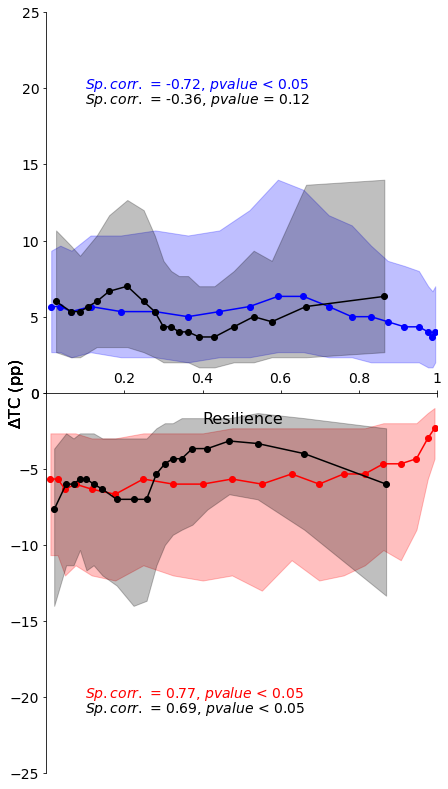

In [15]:
fig = plt.figure(figsize=(7,14))
ax = [plt.subplot(211), plt.subplot(212)]
fig.subplots_adjust(wspace=0.0)
fig.subplots_adjust(hspace=0.0)


a = RZS_TC[['Pred','TC_f-i','Pred_P']].where((RZS_TC['Mean_TC'] >30) & (RZS_TC['TC_f-i'] >= 0)).dropna()
pixel_4 = round(len(a['Pred'].sort_values())/20)

Res_bins = []
Res_bins.append(0)
for i in range(20):
    if i < 19:
        Res_bins.append((a['Pred'].sort_values()[pixel_4*i:pixel_4*(i+1)]).max())
    else:
        Res_bins.append((a['Pred'].sort_values()[pixel_4*i:].max()))

Res_bins[20] = 1
res = []
res_25 = []
res_75 = []
n = []
Res_bins_cen = []
for i in range(np.array(Res_bins).shape[0]-1):
    Res_bins_cen.append((Res_bins[i]+Res_bins[i+1])/2)
for i in range(np.array(Res_bins).shape[0]-1):
    b = a.where((a['Pred'] >= Res_bins[i]) & (a['Pred'] < Res_bins[i+1])).dropna()
    res.append(b['TC_f-i'].median())
    n.append(b['TC_f-i'].size)
    res_25.append(b['TC_f-i'].quantile(0.25))
    res_75.append(b['TC_f-i'].quantile(0.75))
ax[0].plot(np.array(Res_bins_cen),res, '-o', color = 'b')
ax[0].fill_between(np.array(Res_bins_cen),res_25,res_75, alpha = 0.25, color = 'b')
ax[0].set_ylim(0,25)
ax[0].set_xlim(0,1)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].text(-0.1,-2, r'$\Delta {}$'+'TC (pp)', fontsize = '16', rotation = 90)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_xticklabels([' '])
from scipy import stats
cor, p = stats.spearmanr(np.array(Res_bins_cen),res)
if p <= 0.05:
    ax[0].text(0.1,20, r'$Sp. corr.$ = '+str(round(cor,2))+ r', $pvalue$ < 0.05', color = 'b', fontsize = '14')
else:
    ax[0].text(0.1,20, r'$Sp. corr.$ = '+str(round(cor,2))+ r', $pvalue$ = '+str(round(p,2)), color = 'b', fontsize = '14')


pixel_4 = round(len(a['Pred_P'].sort_values())/20)
Res_bins = []
Res_bins.append(0)
for i in range(20):
    if i < 19:
        Res_bins.append((a['Pred_P'].sort_values()[pixel_4*i:pixel_4*(i+1)]).max())
    else:
        Res_bins.append((a['Pred_P'].sort_values()[pixel_4*i:].max()))

Res_bins[20] = 1
res = []
res_25 = []
res_75 = []
n = []
Res_bins_cen = []
for i in range(np.array(Res_bins).shape[0]-1):
    Res_bins_cen.append((Res_bins[i]+Res_bins[i+1])/2)
for i in range(np.array(Res_bins).shape[0]-1):
    b = a.where((a['Pred_P'] >= Res_bins[i]) & (a['Pred_P'] < Res_bins[i+1])).dropna()
    res.append(b['TC_f-i'].median())
    n.append(b['TC_f-i'].size)
    res_25.append(b['TC_f-i'].quantile(0.25))
    res_75.append(b['TC_f-i'].quantile(0.75))
ax[0].plot(np.array(Res_bins_cen),res, '-o', color = 'black')
ax[0].fill_between(np.array(Res_bins_cen),res_25,res_75, alpha = 0.25, color = 'black')
ax[0].set_ylim(0,25)
ax[0].set_xlim(0,1)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].text(-0.1,-2, r'$\Delta {}$'+'TC (pp)', fontsize = '16', rotation = 90)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_xticklabels([' '])
from scipy import stats
cor, p = stats.spearmanr(np.array(Res_bins_cen),res)
if p <= 0.05:
    ax[0].text(0.1,19, r'$Sp. corr.$ = '+str(round(cor,2))+ r', $pvalue$ < 0.05', color = 'black', fontsize = '14')
else:
    ax[0].text(0.1,19, r'$Sp. corr.$ = '+str(round(cor,2))+ r', $pvalue$ = '+str(round(p,2)), color = 'black', fontsize = '14')


a = RZS_TC[['Pred','TC_f-i','Pred_P']].where((RZS_TC['Mean_TC'] >30) & (RZS_TC['TC_f-i'] < 0)).dropna()

pixel_4 = round(len(a['Pred'].sort_values())/20)
Res_bins = []
Res_bins.append(0)
for i in range(20):
    if i < 19:
        Res_bins.append((a['Pred'].sort_values()[pixel_4*i:pixel_4*(i+1)]).max())
    else:
        Res_bins.append((a['Pred'].sort_values()[pixel_4*i:].max()))

Res_bins[20] = 1

res = []
res_25 = []
res_75 = []
n = []
Res_bins_cen = []
for i in range(np.array(Res_bins).shape[0]-1):
    Res_bins_cen.append((Res_bins[i]+Res_bins[i+1])/2)
for i in range(np.array(Res_bins).shape[0]-1):
    b = a.where((a['Pred'] >= Res_bins[i]) & (a['Pred'] < Res_bins[i+1])).dropna()
    res.append(b['TC_f-i'].median())
    n.append(b['TC_f-i'].size)
    res_25.append(b['TC_f-i'].quantile(0.25))
    res_75.append(b['TC_f-i'].quantile(0.75))
ax[1].plot(np.array(Res_bins_cen),res, '-o', color = 'r')
ax[1].fill_between(np.array(Res_bins_cen),res_25,res_75, alpha = 0.25, color = 'r')
ax[1].set_ylim(-25,0)
ax[1].set_xlim(0,1)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].text(-0.1,-2, r'$\Delta {}$'+'TC (pp)', fontsize = '16', rotation = 90)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].set_xticklabels([' '])
from scipy import stats
cor, p = stats.spearmanr(np.array(Res_bins_cen),res)

if p <= 0.05:
    ax[1].text(0.1,-20, r'$Sp. corr.$ = '+str(round(cor,2))+ r', $pvalue$ < 0.05', color = 'r', fontsize = '14')
else:
    ax[1].text(0.1,-20, r'$Sp. corr.$ = '+str(round(cor,2))+ r', $pvalue$ = '+str(round(p,2)), color = 'r', fontsize = '14')

    
pixel_4 = round(len(a['Pred_P'].sort_values())/20)
Res_bins = []
Res_bins.append(0)
for i in range(20):
    if i < 19:
        Res_bins.append((a['Pred_P'].sort_values()[pixel_4*i:pixel_4*(i+1)]).max())
    else:
        Res_bins.append((a['Pred_P'].sort_values()[pixel_4*i:].max()))

Res_bins[20] = 1

res = []
res_25 = []
res_75 = []
n = []
Res_bins_cen = []
for i in range(np.array(Res_bins).shape[0]-1):
    Res_bins_cen.append((Res_bins[i]+Res_bins[i+1])/2)
for i in range(np.array(Res_bins).shape[0]-1):
    b = a.where((a['Pred_P'] >= Res_bins[i]) & (a['Pred_P'] < Res_bins[i+1])).dropna()
    res.append(b['TC_f-i'].median())
    n.append(b['TC_f-i'].size)
    res_25.append(b['TC_f-i'].quantile(0.25))
    res_75.append(b['TC_f-i'].quantile(0.75))
ax[1].plot(np.array(Res_bins_cen),res, '-o', color = 'black')
ax[1].fill_between(np.array(Res_bins_cen),res_25,res_75, alpha = 0.25, color = 'black')
ax[1].set_ylim(-25,0)
ax[1].set_xlim(0,1)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].text(-0.1,-2, r'$\Delta {}$'+'TC (pp)', fontsize = '16', rotation = 90)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].set_xticklabels([' ',0.2,0.4,0.6,0.8,1])
ax[1].set_xlim(0,1)
ax[1].xaxis.tick_top()
ax[1].text(0.4,-2, 'Resilience', fontsize = '16')
from scipy import stats
cor, p = stats.spearmanr(np.array(Res_bins_cen),res)
if p <= 0.05:
    ax[1].text(0.1,-21, r'$Sp. corr.$ = '+str(round(cor,2))+ r', $pvalue$ < 0.05', color = 'black', fontsize = '14')
else:
    ax[1].text(0.1,-21, r'$Sp. corr.$ = '+str(round(cor,2))+ r', $pvalue$ = '+str(round(p,2)), color = 'black', fontsize = '14')